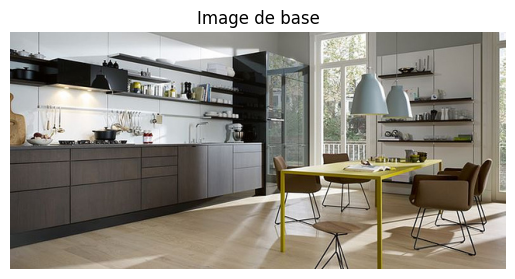

AttributeError: 'RNN_Decoder' object has no attribute 'reset_state'

In [1]:
import tensorflow as tf
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

# Chemin du modèle sauvegardé
model_save_path = "./saved_model2"

# Chargement de l'encodeur et du décodeur
encoder = tf.keras.models.load_model(f"{model_save_path}/encoder")
decoder = tf.keras.models.load_model(f"{model_save_path}/decoder")

# Chargement du tokenizer
with open(f"{model_save_path}/tokenizer.pickle", 'rb') as handle:
    tokenizer = pickle.load(handle)

# Chargement des autres paramètres
with open(f"{model_save_path}/params.pickle", "rb") as handle:
    params = pickle.load(handle)

max_length = params["max_length"]
vocab_size = params["vocab_size"]
attention_features_shape = params["attention_features_shape"]

# Chargement des images et captions de validation
with open(f"{model_save_path}/img_name_val.pkl", 'rb') as f:
    img_name_val = pickle.load(f)

with open(f"{model_save_path}/cap_val.pkl", 'rb') as f:
    cap_val = pickle.load(f)

# Chargement du modèle InceptionV3 pour l'extraction des features
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

# Fonction load_image pour traiter les images
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Fonction pour évaluer une image et générer la légende
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Fonction pour afficher l'attention sur l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

# Tester une image du jeu de validation
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

# Affichage de l'image
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)
plt.axis('off')
plt.title('Image de base')
plt.show()

result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
